# Preprocessing
### Imports

New Python versions sometimes require some extra installations found in the code below

In [1]:
!pip install standard-sunau standard-aifc

In [1]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch.utils.data import DataLoader, Dataset
# Utils
import numpy as np
from numpy import ndarray
import logging
# Base Scripts
from Libraries.Utils import *
from Conf import conf


### Config

In [6]:
remote_kernel: bool = False
training_data_name: str = "training_full_mel"
n_samples: int = 10000
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)
filenames = get_filenames_from_folder(path_to_remote_path(conf["paths"].data_path, remote_kernel), "wav")

2025-06-01 20:17:27,799 - LIGHT_DEBUG - Got filenames ['Am Bach 2024.wav', 'Cutting Mixes mix.wav', 'DA2407_ADO.wav'] from ../Data


### Processing

In [7]:
data: list = []
remaining_samples: int = n_samples
for i in range(len(filenames)):
    file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames[i]), conf["audio"].sample_rate, True)
    file = split_audiofile(file, conf["audio"].time_frame_s, conf["audio"].sample_rate, conf["audio"].overlap)
    file = audio_splits_to_mel_spectograms(file, 2048, 256, 32000, True, 30, 128)
    data.append(file)
    if file.shape[0] < remaining_samples:
        remaining_samples -= file.shape[0]
    else: break

data: ndarray = np.vstack(data)
data = normalize_filewise(data, -1, 1)
data = dimension_for_VAE(data)[:n_samples]
logger.info(f"Processed data of shape: {data.shape}")

2025-06-01 20:17:59,336 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (241901628,), sr: 32000
2025-06-01 20:17:59,792 - LIGHT_DEBUG - Split audio to: (2099, 147200)
2025-06-01 20:17:59,888 - LIGHT_DEBUG - Started Mel-Spec on splits


2025-06-01 20:18:42,000 - LIGHT_DEBUG - Processed Splits: 2090


2025-06-01 20:18:42,900 - LIGHT_DEBUG - Created Mel-spectograms of splits: (2099, 128, 576)
2025-06-01 20:18:54,899 - LIGHT_DEBUG - Loaded audio form ../Data\Cutting Mixes mix.wav of dimensions: (192650642,), sr: 32000
2025-06-01 20:18:55,187 - LIGHT_DEBUG - Split audio to: (1672, 147200)
2025-06-01 20:18:55,244 - LIGHT_DEBUG - Started Mel-Spec on splits


2025-06-01 20:19:30,000 - LIGHT_DEBUG - Processed Splits: 1670


2025-06-01 20:19:30,509 - LIGHT_DEBUG - Created Mel-spectograms of splits: (1672, 128, 576)
2025-06-01 20:19:51,102 - LIGHT_DEBUG - Loaded audio form ../Data\DA2407_ADO.wav of dimensions: (246022144,), sr: 32000
2025-06-01 20:19:51,513 - LIGHT_DEBUG - Split audio to: (2135, 147200)
2025-06-01 20:19:51,629 - LIGHT_DEBUG - Started Mel-Spec on splits


2025-06-01 20:20:39,000 - LIGHT_DEBUG - Processed Splits: 2130


2025-06-01 20:20:40,115 - LIGHT_DEBUG - Created Mel-spectograms of splits: (2135, 128, 576)
2025-06-01 20:20:41,917 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-06-01 20:20:42,021 - INFO - Processed data of shape: (5906, 128, 576)


### Saving

In [8]:
save_training_data(data, f"{path_to_remote_path(conf["paths"].data_path, remote_kernel)}/{training_data_name}.npy")

2025-06-01 20:26:32,052 - LIGHT_DEBUG - Saved ndarray to:../Data/training_full_mel.npy


### Test Blocks

In [7]:
print(np.min(data), np.max(data))

-1.0 1.0


In [3]:
file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames[0]), conf["audio"].sample_rate, True)
file = split_audiofile(file, 4.6, conf["audio"].sample_rate, conf["audio"].overlap)

2025-06-01 20:15:19,382 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (241901628,), sr: 32000
2025-06-01 20:15:19,953 - LIGHT_DEBUG - Split audio to: (2099, 147200)


2025-06-01 20:16:48,859 - LIGHT_DEBUG - Started Mel-Spec
2025-06-01 20:16:48,887 - LIGHT_DEBUG - Created mel-spectogram: (128, 576)
2025-06-01 20:16:48,889 - LIGHT_DEBUG - Normalized to range: [-1,1]


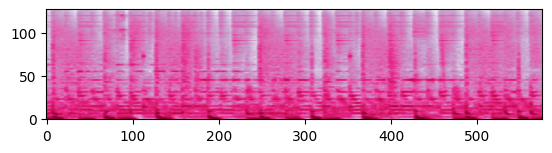

In [5]:
spec = audio_to_mel_spectogram(file[70], 2048, 256, 32000, True, min_freq=30, n_mels=128)
spec = normalize(spec, -1, 1)
plt.imshow(spec, cmap = "PuRd", origin="lower")
plt.show()
#save_audio_file(spectrogram_to_audio(spec, 480, 288, conf["audio"].sample_rate), "../Results/low_res.wav", sample_rate=conf["audio"].sample_rate)